In [1]:
from cluster_model import get_dataset, get_transformer, DATASET_NAME, MODEL_NAME, SEED, N_DATASIZE, get_block_out_label, N_BLOCKS
import cluster_model

ds = get_dataset(DATASET_NAME)
model, _ = get_transformer(MODEL_NAME)
shuffled = ds.shuffle(seed=SEED)['train'][:N_DATASIZE]['text']

ds = shuffled
labs = [get_block_out_label(i) for i in range(N_BLOCKS)]

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda


In [2]:
import kernel
import importlib
importlib.reload(cluster_model)
importlib.reload(kernel)

# TODO: auto sim cutoff needed
decomp = cluster_model.Decomposer(model, ds, labs)
decomp.load()

Creating decomposer with parameter hash bc59bc4fbdc5fbf0582034fc1f46b24d5a7e80f2
Created dataset
Loading dataset from cache
Got embeddings
Getting cluster scores for lattice
Set all initial to 0
Trying to set dataset for layer 0
Set dataset for layer 0 Getting proba
FEATURES (1, 1024, 512) [[[ 1.  0.  0. ...  0.  0.  0.]
  [-1. -0. -0. ... -0. -0. -0.]
  [ 0.  1.  0. ...  0.  0.  0.]
  ...
  [-0. -0. -0. ... -0. -1. -0.]
  [ 0.  0.  0. ...  0.  0.  1.]
  [-0. -0. -0. ... -0. -0. -1.]]]
Set predictions for layer 0
Trying to set dataset for layer 1
Set dataset for layer 1 Getting proba
FEATURES (1, 1024, 512) [[[ 1.  0.  0. ...  0.  0.  0.]
  [-1. -0. -0. ... -0. -0. -0.]
  [ 0.  1.  0. ...  0.  0.  0.]
  ...
  [-0. -0. -0. ... -0. -1. -0.]
  [ 0.  0.  0. ...  0.  0.  1.]
  [-0. -0. -0. ... -0. -0. -1.]]]
Set predictions for layer 1
Trying to set dataset for layer 2
Set dataset for layer 2 Getting proba
FEATURES (1, 1024, 512) [[[ 1.  0.  0. ...  0.  0.  0.]
  [-1. -0. -0. ... -0. -0. -0

In [3]:
decomp.lattice_scores[0].shape

(1024, 1024)

In [4]:
from typing import List
import utils
importlib.reload(utils)
modified_lattice = decomp.lattice_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.lattice_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

0.0
0.0


## Isolate Specific Neurons

In [5]:
LAYER = 0
NEURON = 128

In [6]:
import numpy as np
import kernel
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render
import graph
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(graph)
importlib.reload(kernel)

N_CHECK = 4

decomp.scores_for_neuron(LAYER, NEURON, n_features_per_neuron=3)

WEIGHTING PER LAYER [1.      0.9     0.81    0.729   0.6561  0.59049] WEIGHTING PER EDGE [0.8     0.64    0.512   0.4096  0.32768]
Getting top 100 paths


/tmp/ipykernel_166125/3561863358.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


([128, 128, 128, 128, 128, 128], 1.058115937228371)
([128, 112, 47, 47, 315, 395], 0.9262254924283712)
([128, 47, 47, 47, 315, 395], 0.9201134924283713)
([128, 112, 47, 47, 315, 346], 0.9252064076283711)
([128, 128, 47, 47, 315, 395], 0.9852606924283712)
([128, 47, 47, 47, 315, 346], 0.9190944076283712)
([128, 112, 47, 47, 315, 474], 0.9243773772283711)
([128, 112, 47, 315, 315, 395], 0.9223977804283713)
([128, 112, 47, 47, 315, 660], 0.9241119564283711)
([128, 128, 47, 47, 315, 346], 0.9842416076283712)
([128, 47, 47, 47, 315, 474], 0.9182653772283712)
([128, 47, 47, 315, 315, 395], 0.9162857804283712)
([128, 47, 47, 47, 315, 660], 0.9179999564283712)
([128, 128, 47, 47, 315, 474], 0.9834125772283712)
([128, 112, 47, 315, 315, 346], 0.9213786956283713)
([128, 128, 47, 315, 315, 395], 0.9814329804283711)
([128, 128, 47, 47, 315, 660], 0.9831471564283711)
([128, 47, 47, 315, 315, 346], 0.9152666956283712)
([128, 112, 47, 315, 315, 474], 0.9205496652283712)
([128, 112, 47, 315, 315, 660]

KeyboardInterrupt: 

## Look at distributions of scores

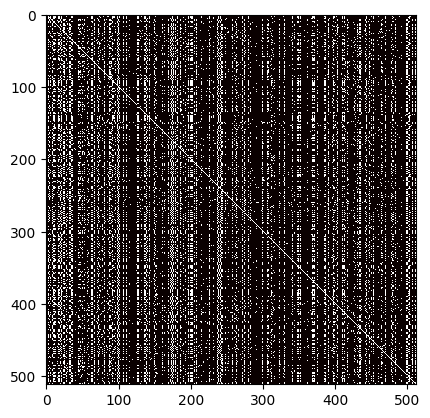

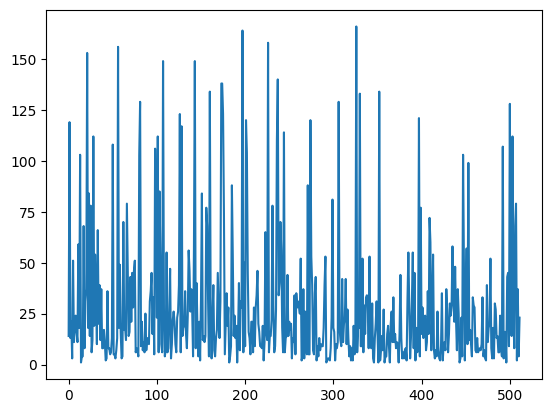

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.1

# ax = sns.heatmap(decomp.lattice_scores[LAYER_START])
plt.imshow((decomp.lattice_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.lattice_scores[3] > cutoff).sum(axis=1))

## Get scores for layers

In [ ]:
decomp.scores_for_layer(0)

WEIGHTING PER LAYER [1.      0.9     0.81    0.729   0.6561  0.59049] WEIGHTING PER EDGE [0.8     0.64    0.512   0.4096  0.32768]
Getting top 100 paths
([0, 0, 0, 0, 0, 0], 1.0029699971748989)
([0, 478, 478, 478, 478, 478], 0.831875021174899)
([0, 326, 326, 326, 326, 197], 0.853473293174899)
([0, 0, 0, 0, 0, 173], 0.979763699574899)
([0, 0, 0, 0, 0, 237], 0.977974566774899)
([0, 0, 0, 0, 0, 330], 0.975277760374899)
([0, 326, 326, 326, 326, 326], 0.8474669187748989)
([0, 0, 0, 0, 0, 500], 0.974193139574899)
([0, 0, 0, 0, 0, 80], 0.973334617974899)
([0, 0, 0, 0, 0, 498], 0.971935424374899)
([0, 326, 326, 326, 326, 107], 0.8437411971748989)
([0, 326, 326, 326, 326, 202], 0.8429121667748989)
([0, 326, 326, 326, 326, 226], 0.8425713795748989)
([0, 326, 326, 326, 326, 21], 0.8421486723748989)
([0, 0, 0, 0, 0, 174], 0.967495360374899)
([0, 0, 0, 0, 0, 274], 0.9674494851748989)
([0, 326, 326, 326, 326, 143], 0.8403464323748989)
([0, 326, 326, 326, 326, 201], 0.8402251907748989)
([0, 326, 326,

KeyboardInterrupt: 